# Simulation Methods Benchmark
In this notbook, we investigate how the error, time, and memory complexity of different quantum simulation tools, namely qutip and the trotter methods, scales with increasing number of qubits. 

The Hamiltonian to be used in this notebook is:
\begin{equation}\label{Trapped Ions Hamiltonian}H = -\sum_{i,j}J_{i,j}\sigma_i^z \sigma_j^z - h \sum\sigma_j^x  \end{equation}

The Trotter-Suzuki formula we can approximate the multiplication of two non-commmuting operaters in the exponent to:
$$ e^{xAB} = \lim_{n \to 0}(e^{xA/n}e^{xB/n})^n $$
Where A and B are operators. For the purpose of this notebook, we will take $ A = \sum_{i,j}J_{i,j}\sigma_i^z \sigma_j^z$ and $B = h \sum\sigma_j^x $.

We will use the default qutip options for this notebook.

Both methods will be compared to the numerical solution using np.expm(). 





Libraries:

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# qutip
from qutip import *

# Numerical
from scipy.linalg import expm
from scipy.sparse.linalg import expm as sparse_expm

# Trotter
from numpy.linalg import matrix_power

# Time performance
import time

# 
from scipy import sparse


print("done")

done


## N-qubits simulation using qutip 

In [175]:
# perfrom qutip simulation for an n-qubits system where n = len(J). 
# initial_state must be a ket qutip Qobj representing the initial_state of the system with shape(2^n, 1).
# J must be an nxn matrix and h must be a real number.
# times is a list of time points for which it is desired to know the state of the system.
# options is of type Options() to control the qutip integrator.
# returns a list of Qobj of type ket representing the state of the system at every time point in times.
# returns the time needed to simulate
def qutip_simulate(initial_state, J, h, times, options):
    
    # Time performance
    begin_time = time.time()
    
    N = len(J)
    H = construct_hamiltonian(J, h)
    result = sesolve(H, initial_state, times, options = options)
    return result.states, time.time() - begin_time


# Construct the Trapped Ion Hamiltonian (Top section) for an n-qubits system where n = len(J) for a given J and h
# J must be an nxn matrix and h must be a real number
# returns a qutip Qobj representing the Trapped Ion Hamiltonian for the n-qubits system
def construct_hamiltonian(J, h):
    N = len(J)
    
    sum_sx = []
    # build h times sum sigma_j^x
    for i in range(N):
        # make a list of N qeye matrices for one qubit
        op_list = []
        for _ in range(N):
            op_list.append(qeye(2))  
        # replace the jth element with sigmax, tensor, then append sum_sx
        op_list[i] = sigmax()
        sum_sx.append(h*tensor(op_list))
        
    sum_sz_sz = []
    # bild sum J_{i,j} sigma_i^z sigma_j^z, we ignore the case where i = j
    for i in range(N):      
        for j in range(N):
            if i == j:
                continue
            # make a list of N qeye matrices for one qubit
            op_list = []
            for _ in range(N):
                op_list.append(qeye(2))  
            # replace the ith and jth elements with sigma_z, tensor, then append to sum_sz_sz
            op_list[i] = sigmaz()
            op_list[j] = sigmaz()
            sum_sz_sz.append(J[i][j]*tensor(op_list))
    H = 0
    for op in sum_sz_sz:
        H -= op
    for op in sum_sx:
        H -=op
    return H


## N-qubits simulation using the Trotter-Suzuki formula

In [82]:
# perfrom Trotter formula simulation for an n-qubits system where n = len(J). 
# initial_state must be a ket qutip Qobj representing the initial_state of the system with shape(2^n, 1).
# J must be an nxn matrix and h must be a real number.
# Trotter_num is a integer
# times is a list of time points for which it is desired to know the state of the system.
# returns a list representing the state of the system at every time point in times.
# returns the time needed to simulate

def trotter_sim(initial_state, J, h, trotter_num, times):
    # Time performance
    begin_time = time.time()
    
    initial_state = np.asarray(initial_state)
    
    N = len(J)

    sum_sx = []
    # build h times sum sigma_j^x
    for i in range(N):
        # make a list of N qeye matrices for one qubit
        op_list = []
        for _ in range(N):
            op_list.append(qeye(2))  
        # replace the jth element with sigmax, tensor, then append sum_sx
        op_list[i] = sigmax()
        sum_sx.append(h*tensor(op_list))
        
    B = 0
    for op in sum_sx:
        B -= op
    B = np.asarray(B)
    
    sum_sz_sz = []
    # bild sum J_{i,j} sigma_i^z sigma_j^z, we ignore the case where i = j
    for i in range(N):      
        for j in range(N):
            if i == j:
                continue
            # make a list of N qeye matrices for one qubit
            op_list = []
            for _ in range(N):
                op_list.append(qeye(2))  
            # replace the ith and jth elements with sigma_z, tensor, then append to sum_sz_sz
            op_list[i] = sigmaz()
            op_list[j] = sigmaz()
            sum_sz_sz.append(J[i][j]*tensor(op_list))
            
    A = 0        
    for op in sum_sz_sz:
        A -= op
    A = np.asarray(A)
    
    # IMPORTANT: if we are simulating a 1-qubit system, there won't be a sum_sz_sz term
    # so we don't have to perform the matrix multiplication of np.matmul(expm(-1j*A*1/trotter_num), expm(-1j*B*1/trotter_num))
    states = []
    if N == 1:
        for t in times:
            U = expm(-1j*B*t/trotter_num)
            U = matrix_power(U, trotter_num)
            states.append(np.matmul(U, initial_state))
    else:
        for t in times:
            U = np.matmul(expm(-1j*A*t/trotter_num), expm(-1j*B*t/trotter_num))
            U = matrix_power(U, trotter_num)
            states.append(np.matmul(U, initial_state))            
    return states, time.time() - begin_time

# This algorithm perform the same things as trotter_sim but with sparse matrcies rather than normal matricies.
def sparse_trotter_sim(initial_state, J, h, trotter_num, times):
    # Time performance
    begin_time = time.time()
    
    initial_state = np.asarray(initial_state)
    
    N = len(J)

    sum_sx = []
    # build h times sum sigma_j^x
    for i in range(N):
        # make a list of N qeye matrices for one qubit
        op_list = []
        for _ in range(N):
            op_list.append(qeye(2))  
        # replace the jth element with sigmax, tensor, then append sum_sx
        op_list[i] = sigmax()
        sum_sx.append(h*tensor(op_list))
        
    B = 0
    for op in sum_sx:
        B -= op
    B = np.asarray(B)
    B = sparse.csr_matrix(B)
    
    sum_sz_sz = []
    # bild sum J_{i,j} sigma_i^z sigma_j^z, we ignore the case where i = j
    for i in range(N):      
        for j in range(N):
            if i == j:
                continue
            # make a list of N qeye matrices for one qubit
            op_list = []
            for _ in range(N):
                op_list.append(qeye(2))  
            # replace the ith and jth elements with sigma_z, tensor, then append to sum_sz_sz
            op_list[i] = sigmaz()
            op_list[j] = sigmaz()
            sum_sz_sz.append(J[i][j]*tensor(op_list))
            
    A = 0        
    for op in sum_sz_sz:
        A -= op
    A = np.asarray(A)
    A = sparse.csr_matrix(A)
    
    # IMPORTANT: if we are simulating a 1-qubit system, there won't be a sum_sz_sz term
    # so we don't have to perform the matrix multiplication of np.matmul(expm(-1j*A*1/trotter_num), expm(-1j*B*1/trotter_num))
    states = []
    if N == 1:
        for t in times:
            U = sparse_expm(-1j*B*t/trotter_num)
            U = U**trotter_num
            states.append(U @ initial_state)
    else:
        for t in times:
            U = sparse_expm(-1j*A*t/trotter_num) @ sparse_expm(-1j*B*t/trotter_num)
            U = U**trotter_num
            states.append(U @ initial_state)        
    return states, time.time() - begin_time

## N-qubits Numerical Simulation using np.expm()

In [157]:
def numerical_sim(initial_state, J, h, times):
    # Time performance
    begin_time = time.time()
    
    H_numerical = np.asarray(construct_hamiltonian(J, h))

    initial_state_numerical = np.asarray(initial_state)

    numerical_states = []
    for t in times:
        U = expm(-1j*H_numerical*t)
        mult = np.matmul(U, initial_state_numerical)
        numerical_states.append(mult)
    return numerical_states, time.time() - begin_time

# Sanity Check
Here we perform the three simulations on a two qubits case to check if we can generate the same result acquired in notbooks: 10- Trotter Simulation and 9- Trapped_Ions_Hamiltonian.

In [158]:
# Params
h = 1
J = np.array([[1, 1], [1, 1]])
initial_state = tensor(basis(2, 0), basis(2, 0))
trotter_num = 100
times = np.linspace(0.0, 10, 100)

# Numerical
numerical_states, t = numerical_sim(initial_state, J, h, times)

# qutip
options = Options()
qutip_states, t = qutip_simulate(initial_state, J, h, times, options)

# Trotter
trotter_states, t = trotter_sim(initial_state, J, h, trotter_num, times)

print("done")

done


Text(0.5, 1.0, 'Error in qutip for the trapped ions hamiltonian against numerical solution')

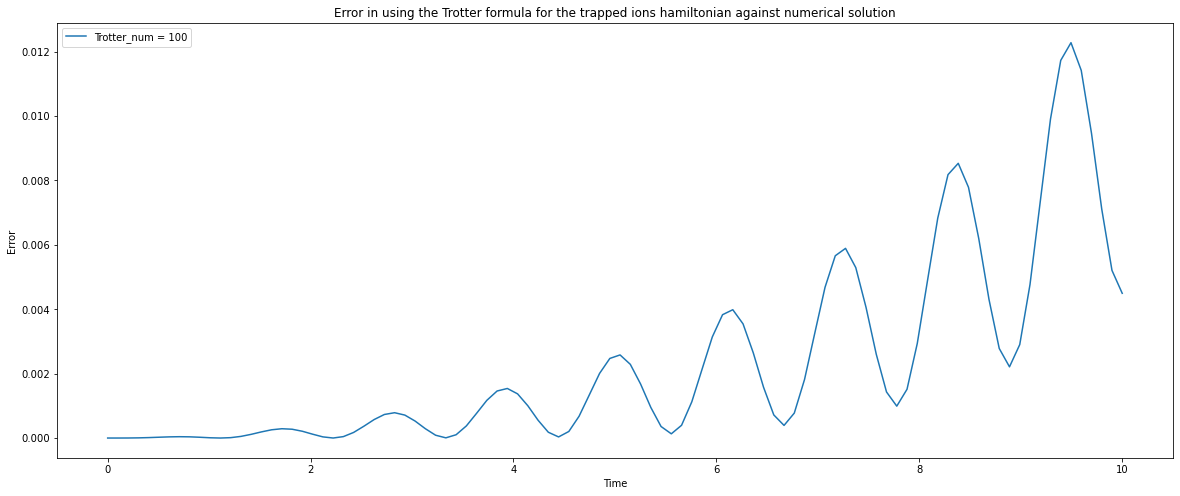

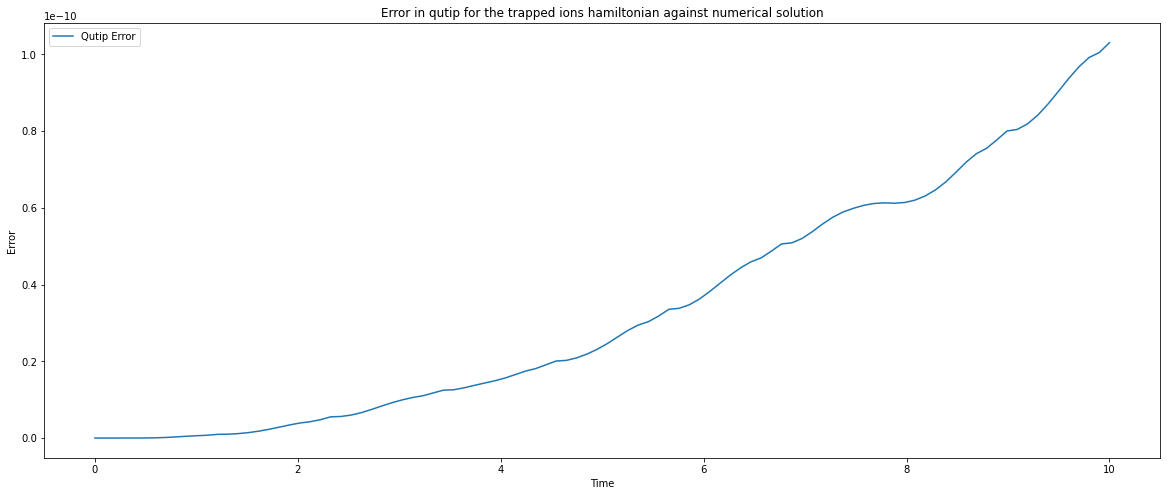

In [159]:
trotter_error = []
qutip_error = []
for i in range(len(times)):
    y = []
    y.append(trotter_states[i][0] - numerical_states[i][0])
    y.append(trotter_states[i][1] - numerical_states[i][1])
    y.append(trotter_states[i][2] - numerical_states[i][2])
    y.append(trotter_states[i][3] - numerical_states[i][3])
    trotter_error.append(np.abs(np.vdot(y, y)))
    y = []
    y.append(qutip_states[i][0] - numerical_states[i][0])
    y.append(qutip_states[i][1] - numerical_states[i][1])
    y.append(qutip_states[i][2] - numerical_states[i][2])
    y.append(qutip_states[i][3] - numerical_states[i][3])
    qutip_error.append(np.abs(np.vdot(y, y)))

p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(times, trotter_error) 
p.legend(("Trotter_num = 100",))
p.set_xlabel('Time') 
p.set_ylabel('Error') 
p.set_title("Error in using the Trotter formula for the trapped ions hamiltonian against numerical solution")

p = plt.figure(2)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(times, qutip_error) 
p.legend(("Qutip Error",))
p.set_xlabel('Time') 
p.set_ylabel('Error') 
p.set_title("Error in qutip for the trapped ions hamiltonian against numerical solution")


As we can see, the two figures are identical to the figures produced before. The trotter simulation figure is identical to the first figure in the 10- Trotter Simulation notbook and the qutip figure in identical to the third figure in the 9- Trapped_Ions_Hamiltonian notbook. The generlization for n-qubits of the algorithms written in the 9th and 10th notbooks is therefore correct, atleast for the two qubits case.

# Analysis
Here, we investigate the algorithms behavior for different number of qubits starting from 1 qubits system to 12 qubits system. We start with the trotter method by investigating the error for different trotter number as the number of qubits scales. We, then, must generate 12 different Js matrices and 12 different initial_states. All the Js components will be 1. All the initial states will be a tensor product of the state $|0\rangle$.

In [241]:
Js = []
initial_states = []
t_num = 100
trotter_nums = [t_num]
qubits_num = []
for i in range(1, 13):
    qubits_num.append(i)
    Js.append(np.ones((i, i)))
    if i < 6:
        t_num = t_num * 10
        trotter_nums.append(t_num)
    is_list = []
    for _ in range(i):
        is_list.append(basis(2, 0))
    initial_states.append(tensor(is_list))
    
# Params
h = 1
times = np.linspace(0.0, 10, 100)


print("done")

done


## Numerical Solution from 1 to 12 qubits
First, we generate the numerical solution that the other algorithms will be compared to:

In [173]:
numerical_times = []
numerical_states_at_diff_qubits = []

# Time performance
begin_time = time.time()

for i in range(len(Js)):
    states = numerical_sim(initial_states[i], Js[i], h, times)
    numerical_times.append(states[1])
    numerical_states_at_diff_qubits.append(states[0])
    print(str(i + 1) + " qubits: done")
    
numerical_entire_sim_time = time.time() - begin_time
print("done")
print(numerical_entire_sim_time)

done
10334.552875995636


## Trotter Solution from 1 to 12 qubits

In [183]:
trotter_times = []
trotter_states_at_diff_qubits_at_diff_trotter_num = []# a list of a list(states for n qubits at diff trotter nums) 
                                                      # of a list(states for spe)
# Time performance
begin_time = time.time()

for i in range(8):
    t = []
    trotter_states_for_diff_trotter_num = []
    for j in range(len(trotter_nums)):
        states = trotter_sim(initial_states[i], Js[i], h, trotter_nums[j], times)
        trotter_states_for_diff_trotter_num.append(states[0])
        t.append(states[1])
    trotter_states_at_diff_qubits_at_diff_trotter_num.append(trotter_states_for_diff_trotter_num)
    trotter_times.append(t)
    print(str(i + 1) + " qubits: done")
trotter_entire_sim_time = time.time() - begin_time
print("done")
print(trotter_entire_sim_time)

1 qubits: done
2 qubits: done
3 qubits: done
4 qubits: done
5 qubits: done
6 qubits: done
7 qubits: done
8 qubits: done
done
5.183994293212891


## Qutip Solution from 1 to 12 qubits

In [180]:
qutip_times = []
qutip_states_at_diff_qubits = []

# Time performance
begin_time = time.time()

options = Options()


for i in range(len(Js)):
    states = qutip_simulate(initial_states[i], Js[i], h, times, options)
    qutip_times.append(states[1])
    qutip_states_at_diff_qubits.append(states[0])
    print(str(i + 1) + " qubits: done")
    
qutip_entire_sim_time = time.time() - begin_time
print("done")
print(qutip_entire_sim_time)

1 qubits: done
2 qubits: done
3 qubits: done
4 qubits: done
5 qubits: done
6 qubits: done
7 qubits: done
8 qubits: done
9 qubits: done
10 qubits: done
11 qubits: done
12 qubits: done
done
5.183994293212891


## Error
The error is defined as the amplitude of the difference between the state vector of the algorithm being studied and the numerical state vector.

In [199]:
trotter_error = []
for i in range(8):#len(Js)):
    n = len(Js[i]) # nums of qubits currently considered
    t_nums_error = []
    for j in range(len(trotter_nums)):
        error = []
        numerical_states = numerical_states_at_diff_qubits[i]
        trotter_states = trotter_states_at_diff_qubits_at_diff_trotter_num[i][j]
        for k in range(len(times)):
            y = []
            for l in range(2**n):
                y.append(numerical_states[k][l] - trotter_states[k][l])
            error.append(np.abs(np.vdot(y, y)))
        t_nums_error.append(error)
    trotter_error.append(t_nums_error)
print("done")
        

done


In [239]:
qutip_error = []
for i in range(len(Js)):
    n = len(Js[i]) # nums of qubits currently considered
    error = []
    numerical_states = numerical_states_at_diff_qubits[i]
    qutip_states = qutip_states_at_diff_qubits[i]
    for j in range(len(times)):
        y = []
        for k in range(2**n):
#             print(k)
#             print(qutip_states[j][1])
#             s = qutip_states[j][k] 
            y.append(numerical_states[j][k] - qutip_states[j][k])
        error.append(np.abs(np.vdot(y, y)))
    qutip_error.append(error)
print("done")
        

done


Text(0.5, 1.0, 'Error when using qutip to simulate the trapped ions hamiltonian against numerical solution for different qubits number')

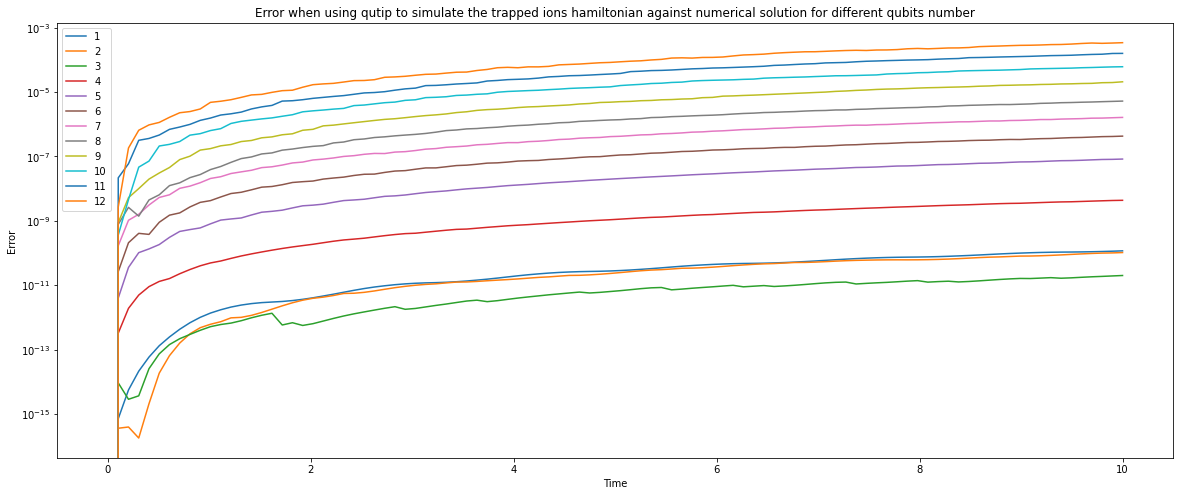

In [281]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot() 
for error in qutip_error:
    p.plot(times, error) 
p.set_yscale('log')
p.legend(qubits_num)
p.set_xlabel('Time') 
p.set_ylabel('Error') 
p.set_title("Error when using qutip to simulate the trapped ions hamiltonian against numerical solution for different qubits number")

Text(0.5, 1.0, 'Qutip Area under error curve for N Qubits')

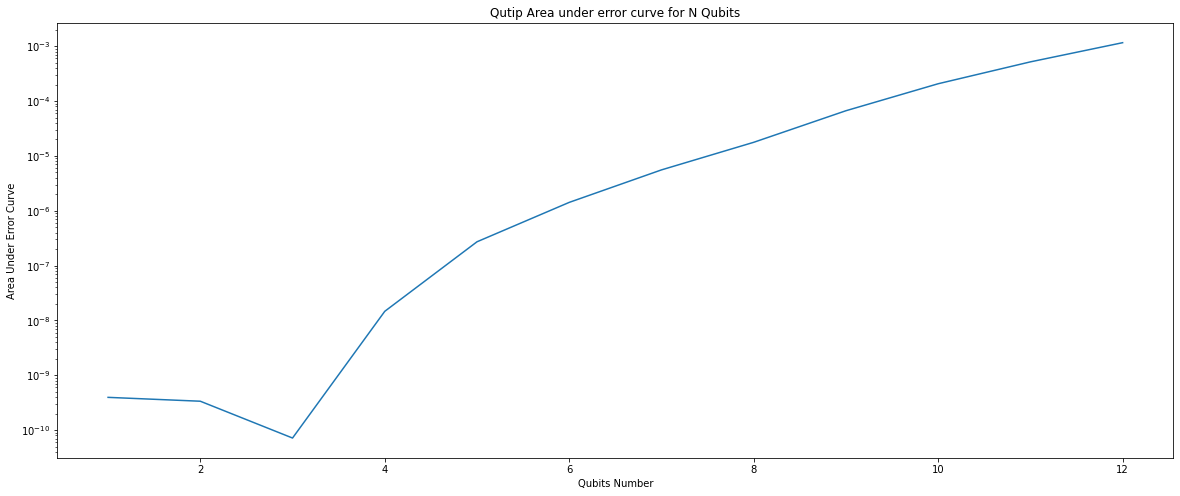

In [282]:
qutip_area_under_error_curve  = []
for error in qutip_error:
    qutip_area_under_error_curve.append(np.trapz(error, times))
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(qubits_num, qutip_area_under_error_curve)
p.set_yscale('log')
p.set_xlabel('Qubits Number') 
p.set_ylabel('Area Under Error Curve') 
p.set_title("Qutip Area under error curve for N Qubits")

Text(0.5, 1.0, 'Error when using The Trotter-Suzuki formula to simulate the trapped ions hamiltonian against numerical solution for different qubits number(Trotter Number = 10000)')

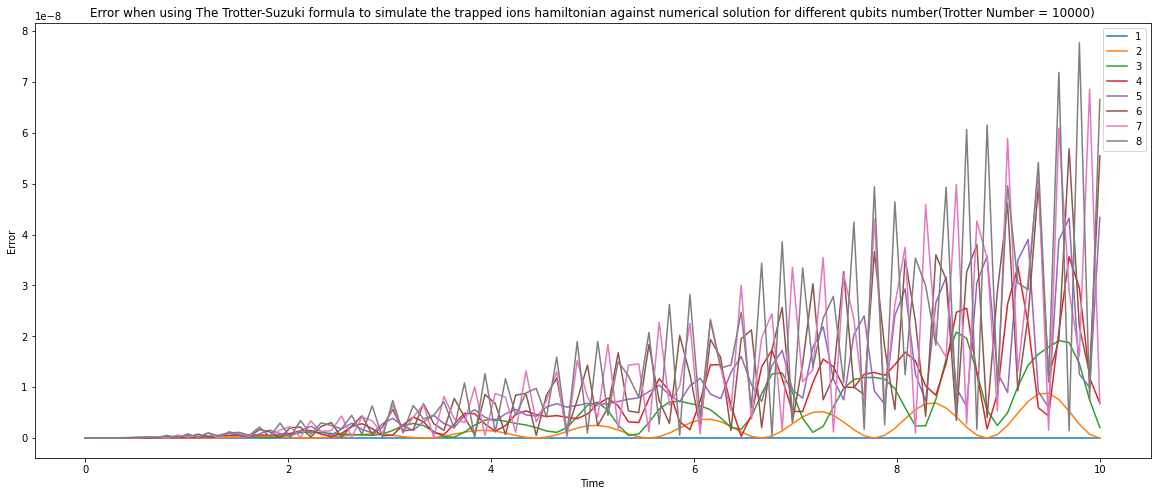

In [268]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
for error in trotter_error:
    p.plot(times, error[3]) 
p.legend(qubits_num)
p.set_xlabel('Time') 
p.set_ylabel('Error') 
p.set_title("Error when using The Trotter-Suzuki formula to simulate the trapped ions hamiltonian against numerical solution for different qubits number(Trotter Number = 10000)")

Text(0.5, 1.0, 'Trotter Area under error curve for N Qubits')

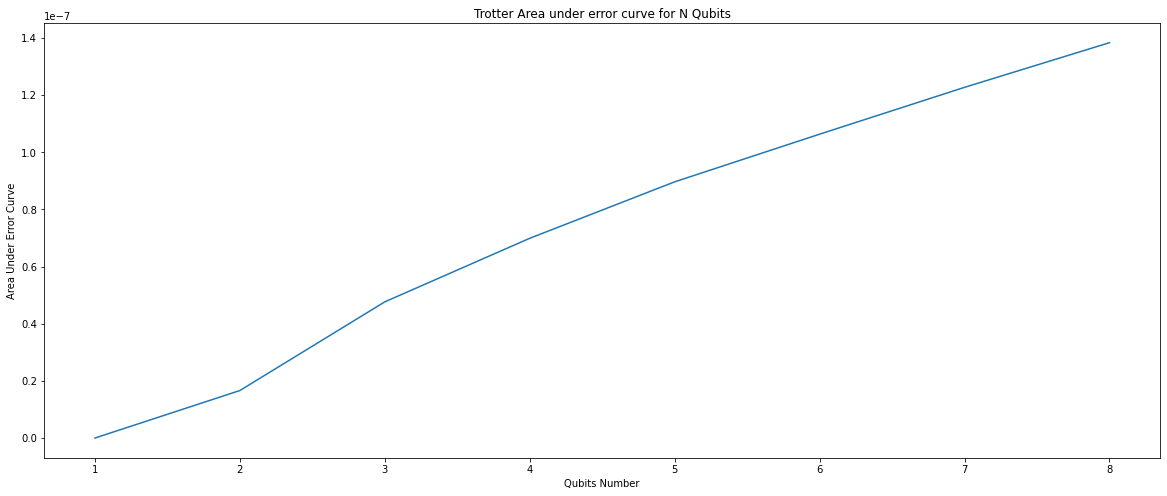

In [272]:
trotter_area_under_error_curve  = []
for error in trotter_error:
    trotter_area_under_error_curve.append(np.trapz(error[3], times))
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(qubits_num[:8], trotter_area_under_error_curve)
p.set_xlabel('Qubits Number') 
p.set_ylabel('Area Under Error Curve') 
p.set_title("Trotter Area under error curve for N Qubits")

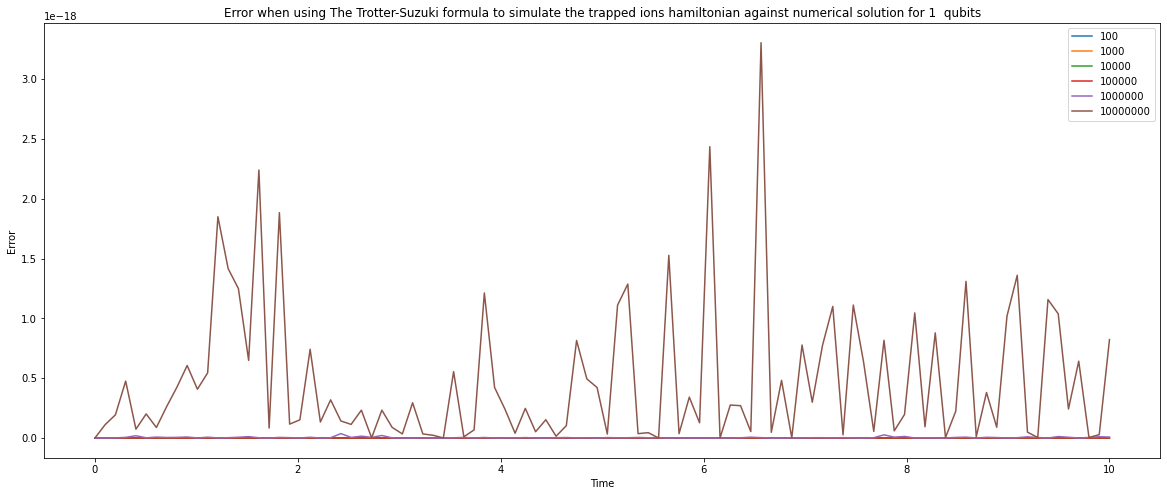

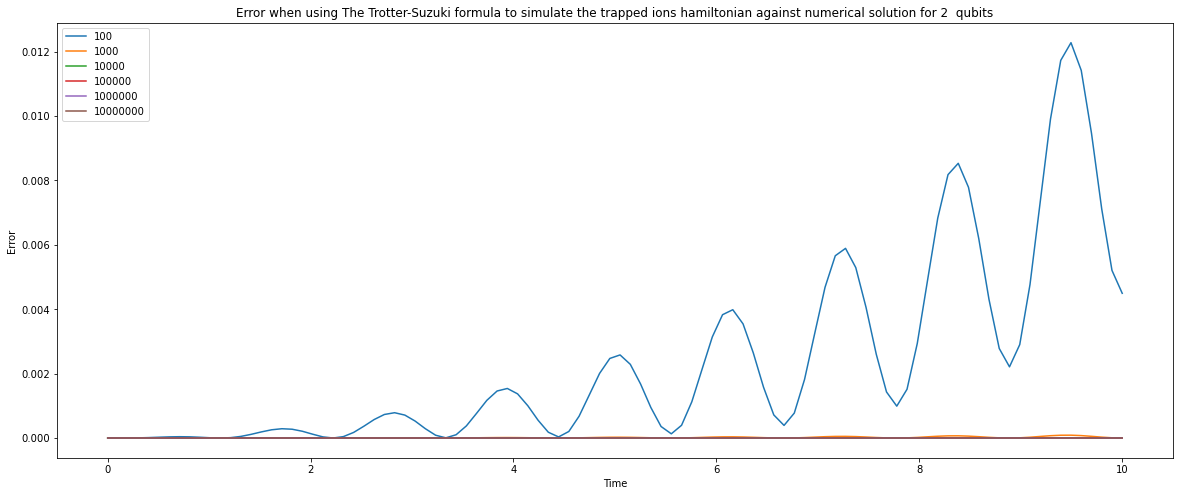

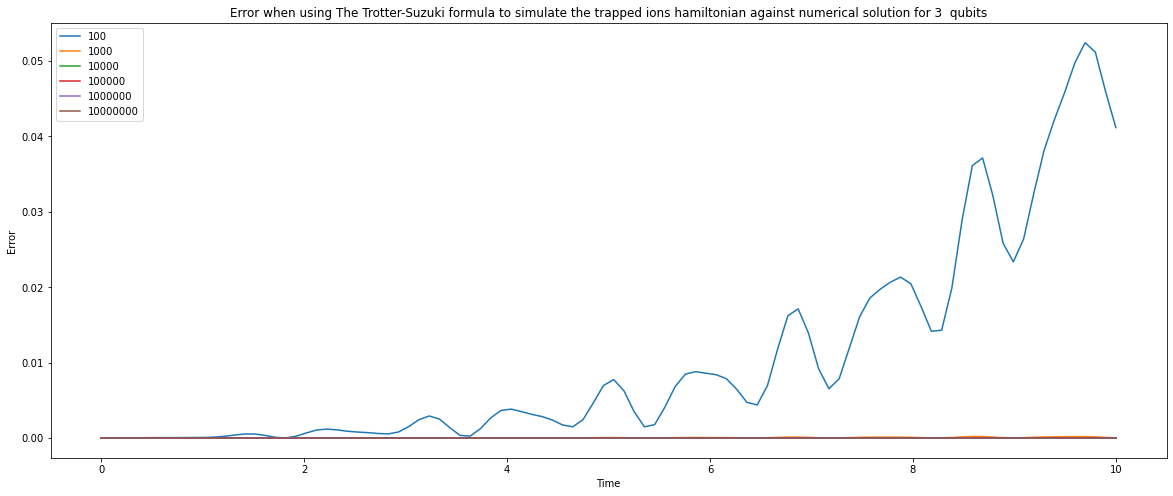

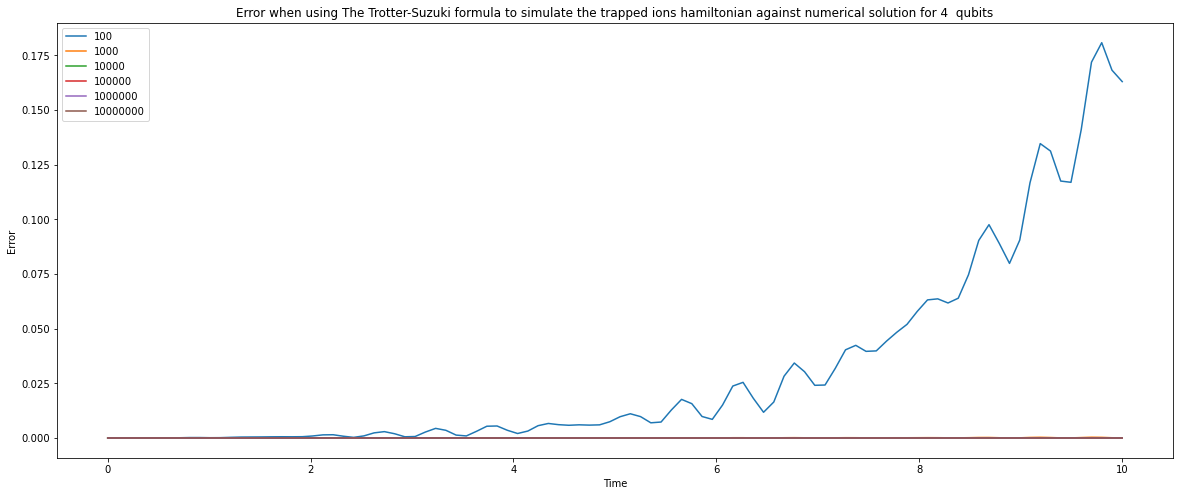

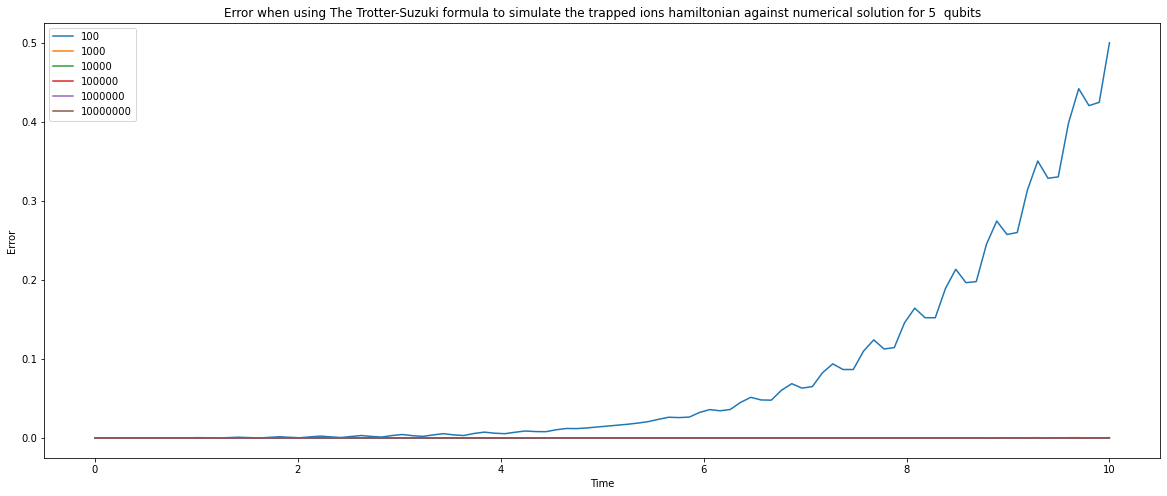

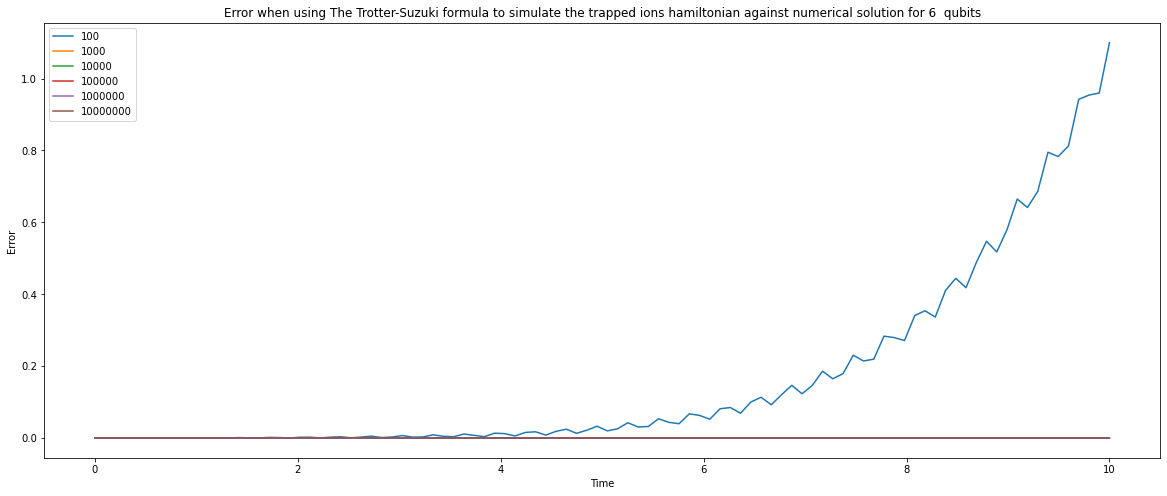

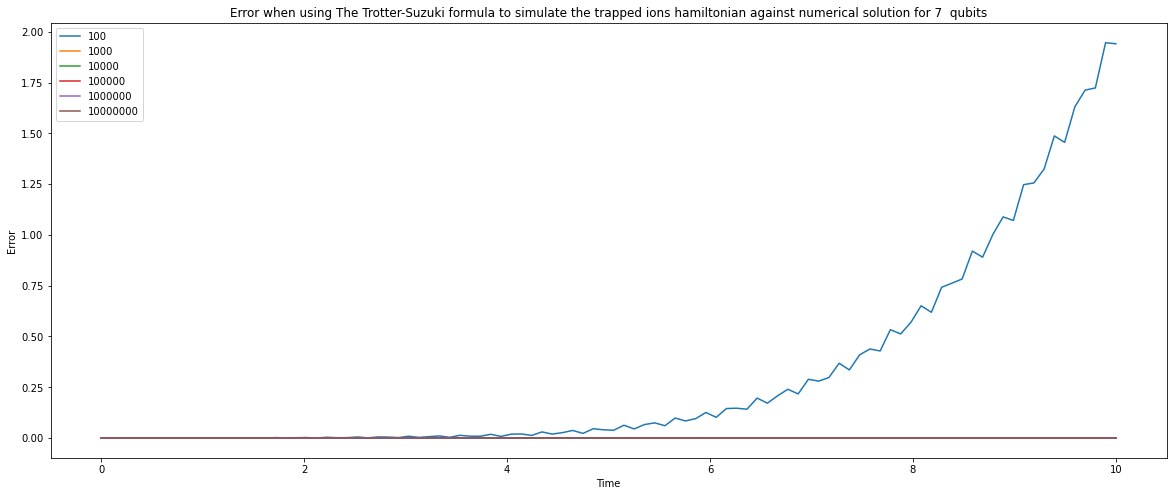

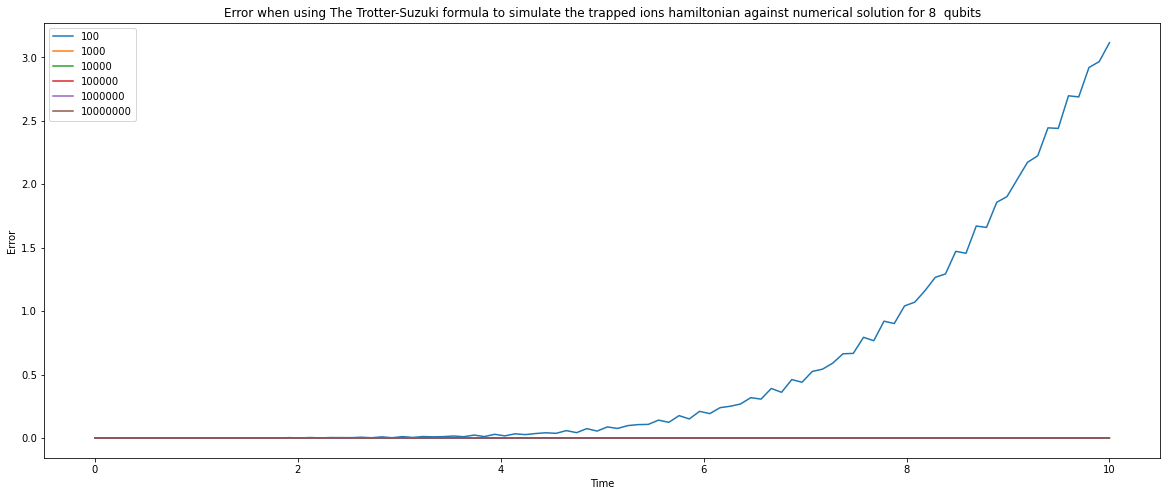

In [280]:
i = 1
for errors in trotter_error:
    p = plt.figure(i)
    p.set_figwidth(20)
    p.set_figheight(8)
    p = plt.subplot()
    for error in errors:
        p.plot(times, error) 
    p.legend(trotter_nums)
    p.set_xlabel('Time') 
    p.set_ylabel('Error') 
    p.set_title("Error when using The Trotter-Suzuki formula to simulate the trapped ions hamiltonian against numerical solution for " + str(i) + "  qubits")
    i += 1

## Time Complexity

Text(0.5, 1.0, 'Qutip Time Complexity for different Qubits number')

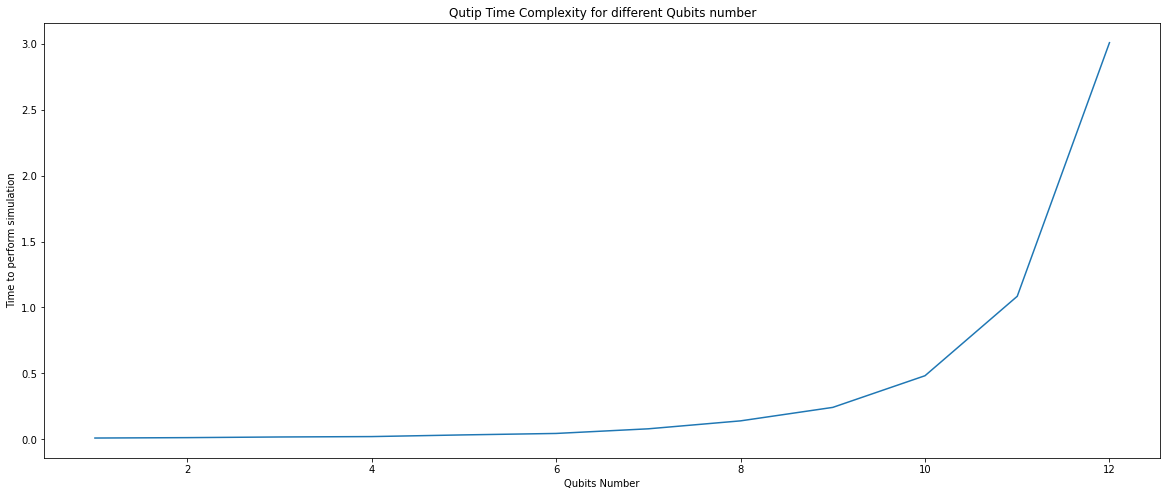

In [274]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(qubits_num, qutip_times)
p.set_xlabel('Qubits Number') 
p.set_ylabel('Time to perform simulation') 
p.set_title("Qutip Time Complexity for different Qubits number")

Text(0.5, 1.0, 'Numerical Time Complexity for different Qubits number')

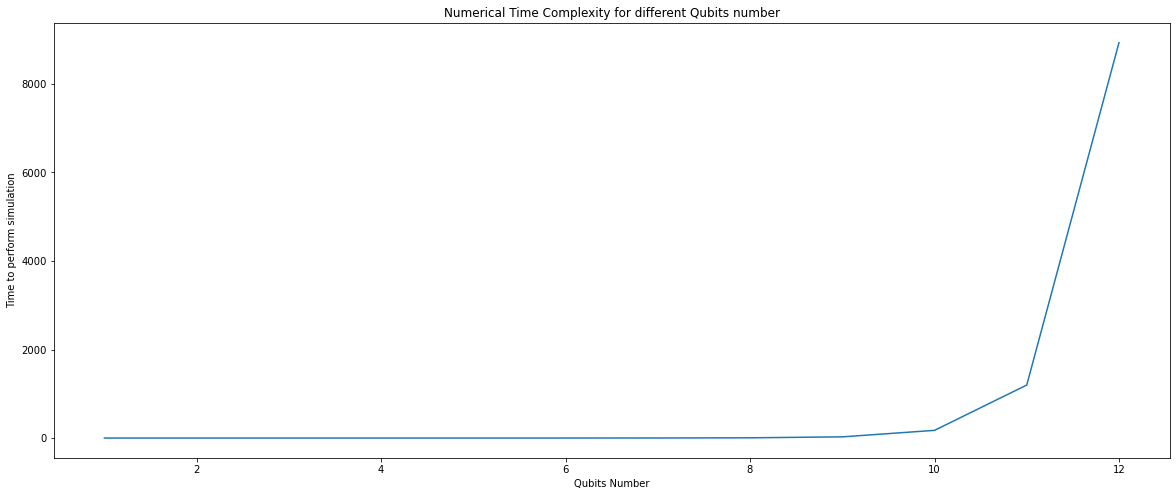

In [276]:
p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
p.plot(qubits_num, numerical_times)
p.set_xlabel('Qubits Number') 
p.set_ylabel('Time to perform simulation') 
p.set_title("Numerical Time Complexity for different Qubits number")

Text(0.5, 1.0, 'Time Complexity of Trotter-Suzuki Forumula for different Qubits number')

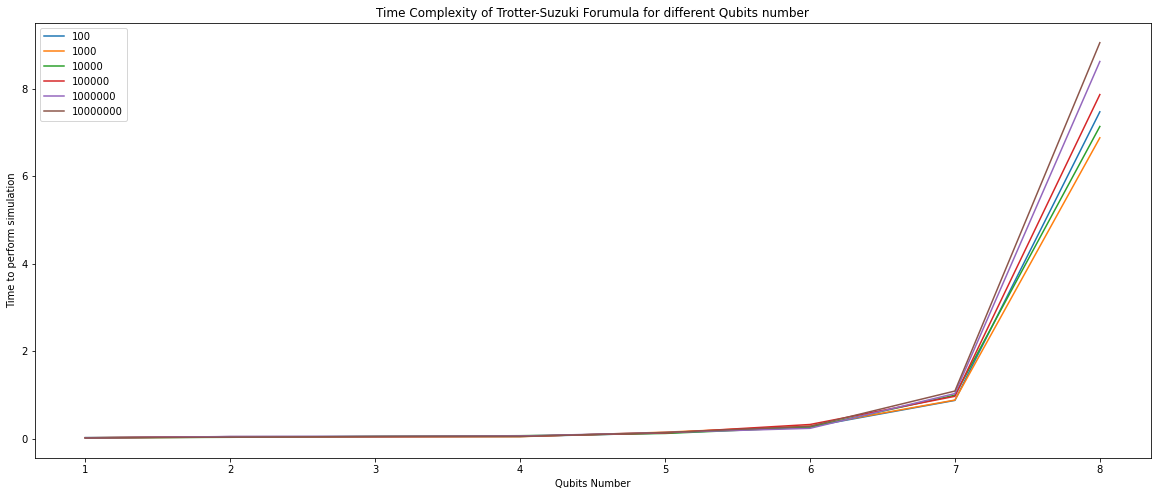

In [278]:
trotter_tc_at_n_qubits = [] # tc = time complexity

for j in range(len(trotter_nums)):
    tc = []
    for i in range(len(trotter_times)):
        tc.append(trotter_times[i][j])
    trotter_tc_at_n_qubits.append(tc)



p = plt.figure(1)
p.set_figwidth(20)
p.set_figheight(8)
p = plt.subplot()
for tc in trotter_tc_at_n_qubits:
    p.plot(qubits_num[:8], tc)
p.legend(trotter_nums)
p.set_xlabel('Qubits Number') 
p.set_ylabel('Time to perform simulation') 
p.set_title("Time Complexity of Trotter-Suzuki Forumula for different Qubits number")